# Quantum Neural Network (QNN) with Qutrits for Wine Dataset

In this notebook, I present the implementation of a Quantum Neural Network (QNN) using qutrits to address the Wine dataset. The Wine dataset is a multi-class classification problem, containing samples from three different types of wines. I'll begin by importing the necessary libraries at the beginning of the notebook.

In [1]:
import numpy as np
from scipy.linalg import expm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
plt.style.use('ipynb')

### Wine Dataset 

This dataset contains the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. In the dataset ingestion step, we'll load the Wine dataset using pandas.

In [30]:
data = pd.read_csv('../../Datasets/wine.data', delimiter=',', header=None)
X = data.iloc[:, 1:13].to_numpy()
labels = data.iloc[:, 0].to_numpy()
y = np.eye(3)[labels - 1]
print(data.head())
print(X[0], y[0])

# Perform PCA to reduce the dimensions to 4
pca = PCA(n_components=4)
reduced_X = pca.fit_transform(X)

# Print the shapes of X and y to verify they match the expected dimensions
print('Shape of X:', X.shape)
print('Reduced  X:', reduced_X.shape)
print('x[0] reduced example: ', reduced_X[0])

   0      1     2     3     4    5     6     7     8     9     10    11    12  \
0   1  14.23  1.71  2.43  15.6  127  2.80  3.06  0.28  2.29  5.64  1.04  3.92   
1   1  13.20  1.78  2.14  11.2  100  2.65  2.76  0.26  1.28  4.38  1.05  3.40   
2   1  13.16  2.36  2.67  18.6  101  2.80  3.24  0.30  2.81  5.68  1.03  3.17   
3   1  14.37  1.95  2.50  16.8  113  3.85  3.49  0.24  2.18  7.80  0.86  3.45   
4   1  13.24  2.59  2.87  21.0  118  2.80  2.69  0.39  1.82  4.32  1.04  2.93   

     13  
0  1065  
1  1050  
2  1185  
3  1480  
4   735  
[ 14.23   1.71   2.43  15.6  127.     2.8    3.06   0.28   2.29   5.64
   1.04   3.92] [1. 0. 0.]
Shape of X: (178, 12)
Reduced  X: (178, 4)
x[0] reduced example:  [27.38095864 -3.58175743 -0.17622328  0.69292339]


Then defining a custom PyTorch dataset class called CustomDataset to handle data and labels. The dataset is scaled using StandardScaler to normalize the input features, the dataset is then split into training and testing sets using train_test_split from scikit-learn, with a test size of 30% and stratified sampling to maintain the class distribution. 

The number of instances for each class in both sets is printed. Finally, the PyTorch datasets and dataloaders are created for the training and testing sets, respectively. The dataloaders enable efficient batch processing during training and evaluation stages in machine learning models.

In [31]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# # scaling the inputs is important since the embedding we use is periodic
scaler = StandardScaler().fit(reduced_X)
X_scaled = scaler.transform(reduced_X)

print(X_scaled[0])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

# Use np.sum to count the number of instances of each class in both sets
print("Class counts in training set:", np.sum(y_train, axis=0))
print("Class counts in test set:", np.sum(y_test, axis=0))

# Create PyTorch datasets and dataloaders
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)


[ 1.92043466 -1.05774943 -0.07459246  0.55054269]
Class counts in training set: [41. 50. 33.]
Class counts in test set: [18. 21. 15.]


Then defining the quantum circuit that forms the core of our QNN. The circuit will comprise layers of qutrit-based quantum gates, allowing for more expressive quantum representations of the input data. This will be followed by the classical optimizer that updates the parameters based on the output and the ground truth labels.

The QNN class employs qutrit states, Gell-Mann matrices, and parameterized rotations to process the input data. The network is composed of multiple layers, each containing weights for Gell-Mann rotations and a bias term. During the forward pass, the QNN applies encoding and variational rotations using the weights and Gell-Mann matrices to manipulate the qutrit states.

In [38]:
class QNN(nn.Module):
    
    def __init__(self, num_layers, num_features):
        super(QNN, self).__init__()

        self.num_layers = num_layers
        self.num_features = num_features
        
        # Define the qutrit states as column vectors
        self.q0 = torch.tensor([[1], [0], [0]], dtype=torch.cfloat)
        self.q1 = torch.tensor([[0], [1], [0]], dtype=torch.cfloat)
        self.q2 = torch.tensor([[0], [0], [1]], dtype=torch.cfloat)

        # Define the Gell-Mann matrices
        self.gm1 = torch.kron(self.q0, self.q1.T) + torch.kron(self.q1, self.q0.T)
        self.gm2 = -1j * (torch.kron(self.q0, self.q1.T) - torch.kron(self.q1, self.q0.T))
        self.gm3 = torch.kron(self.q0, self.q0.T) - torch.kron(self.q1, self.q1.T)
        self.gm4 = torch.kron(self.q0, self.q2.T) + torch.kron(self.q2, self.q0.T)
        self.gm5 = -1j * (torch.kron(self.q0, self.q2.T) - torch.kron(self.q2, self.q0.T))
        self.gm6 = torch.kron(self.q1, self.q2.T) + torch.kron(self.q2, self.q1.T)
        self.gm7 = -1j * (torch.kron(self.q1, self.q2.T) - torch.kron(self.q2, self.q1.T))
        self.gm8 = 1/torch.sqrt(torch.tensor(3., dtype=torch.float)) * (torch.kron(self.q0, self.q0.T) + torch.kron(self.q1, self.q1.T) - 2*torch.kron(self.q2, self.q2.T))
        self.lz = self.gm3 + torch.sqrt(torch.tensor(3., dtype=torch.float)) * self.gm8
        self.lz[1][1]=0
        self.hadamard = (1 / torch.sqrt(torch.tensor(3.0))) * torch.tensor([[1, 1, 1], [1, torch.exp(torch.tensor(2j) * torch.tensor(3.1416 / 3.0)) , torch.exp(torch.tensor(-2j) * torch.tensor(3.1416 / 3.0))], [1, torch.exp(torch.tensor(-2j) * torch.tensor(3.1416 / 3.0)), torch.exp(torch.tensor(2j) * torch.tensor(3.1416 / 3.0))]], dtype=torch.cfloat)
        self.LZZ2 = torch.kron(self.lz, self.lz)

        # Collect the Gell-Mann matrices in a list
        self.generators = [self.gm1, self.gm2, self.gm3, self.gm4, self.gm5, self.gm6, self.gm7, self.gm8]

        # Define the weights
        self.weights = nn.ParameterList()
        self.bias = nn.ParameterList()

        # print(self.num_layers*(int(self.num_features/8)))

        for i in range(self.num_layers*(int(self.num_features/4))):
            
            # Weights for the Gell-Mann rotations
            self.weights.append(nn.Parameter(torch.randn(4, dtype=torch.float)))

            # Weight for the bias term
            self.bias.append(nn.Parameter(torch.randn(1, dtype=torch.float)))

    def forward(self, batch):
        
        logits = torch.empty(batch.shape[0], 3, dtype=torch.double)

        for idx, x in enumerate(batch):

            qutrit_1 = torch.matmul(self.hadamard, self.q0)


            # Apply parameterized rotations using Gell-Mann matrices and Rot(w) weights
            for i in range(self.num_layers*(int(self.num_features/4))):
                
                # Apply the encoding with the Gell-Mann matrices
                gm_weights = self.weights[i]
                
                # The first 4 Features in the first qutrit
                encoded = torch.zeros([3,3], dtype=torch.cfloat)
                for index in range(4):
                    encoded += (1j * x[(index+4*i)%self.num_features] * self.generators[index])
                qutrit_1 = torch.matmul(torch.matrix_exp(encoded), qutrit_1)

                # The first variational for first qutrit
                encoded = torch.zeros([3,3], dtype=torch.cfloat)
                for index in range(4):
                    encoded += (1j * gm_weights[index] * self.generators[index+4])

                # Add bias term with the identity matrix
                encoded += 1j * self.bias[i][0] * torch.eye(3)
                qutrit_1 = torch.matmul(torch.matrix_exp(encoded), qutrit_1)

            # state = torch.kron(qutrit_1, qutrit_2)
            probabilities = torch.abs(qutrit_1.flatten())**2
    
            # Normalize the probabilities   
            probabilities /= torch.sum(probabilities)
            logits[idx] = probabilities

        return logits


Then defining the function `evaluate_accuracy` which calculates evaluation metrics, including accuracy, F1-score, precision, and recall, for a given PyTorch model on the provided test dataset using a dataloader. It iterates over the test data batches and computes the model's predictions. The ground truth labels are also extracted. The calculated metrics are returned, and if verbose is set to True, the evaluation results are printed.

In [33]:
def evaluate_accuracy(test_dataloader, model, verbose=False):

    correct = 0 
    y_pred = []
    y_true = []

    # Evaluate the model on the test data and print the accuracy
    with torch.no_grad():
        
        for batch_idx, (data, target) in enumerate(test_dataloader):
            output = model(data)

            predicted_labels = torch.argmax(output, dim=1)

            # Find the ground truth labels by taking the argmax along the appropriate axis
            ground_truth_labels = torch.argmax(target, dim=1)
            for y in predicted_labels:
                y_pred.append(y.numpy()) 
            for y in ground_truth_labels:
                y_true.append(y.numpy())
            
            correct += (predicted_labels == ground_truth_labels).sum().item()

    accuracy = accuracy_score(y_true, y_pred)* 100
    f1 = f1_score(y_true, y_pred, average='macro')* 100
    precision = precision_score(y_true, y_pred, average='macro')* 100
    recall = recall_score(y_true, y_pred, average='macro')* 100
        
    if(verbose):
        print("Evaluation Results")
        print("_____________________________________________")
        print(
                f"\nRecall: {recall:.2f}%"
                f"\nPrecision: {precision:.2f}%"
                f"\nAccuracy: {accuracy:.2f}%"
                f"\nMacro Averaged F1-score: {f1:.2f}%"
                )
        print("_____________________________________________")
    return accuracy, f1, precision, recall

### Training

Then training of the Quantum Neural Network (QNN) with qutrits for a fixed number of epochs while monitoring the test accuracy. The initial loop run until a good initial point in the parameter space is identified. The model is initialized with 2 layers (LAYERS), and the parameter ranges are constrained using a threshold of 4π. 

The RMSprop optimizer is employed for training, and the CrossEntropyLoss function is used as the loss metric. The training process updates the model's weights using the training data and evaluates its accuracy on both the training and test datasets. Finally, the learning curves (train and test accuracies) are plotted against the number of epochs, visualizing the model's learning progress and performance improvement over time.

Epoch 1:
	Accuracy: 83.3%
Epoch 2:
	Accuracy: 85.2%
Epoch 3:
	Accuracy: 83.3%
Epoch 4:
	Accuracy: 81.5%
Epoch 5:
	Accuracy: 81.5%
Epoch 6:
	Accuracy: 85.2%
Evaluation Results
_____________________________________________

Recall: 84.23%
Precision: 84.61%
Accuracy: 85.19%
Macro Averaged F1-score: 84.37%
_____________________________________________


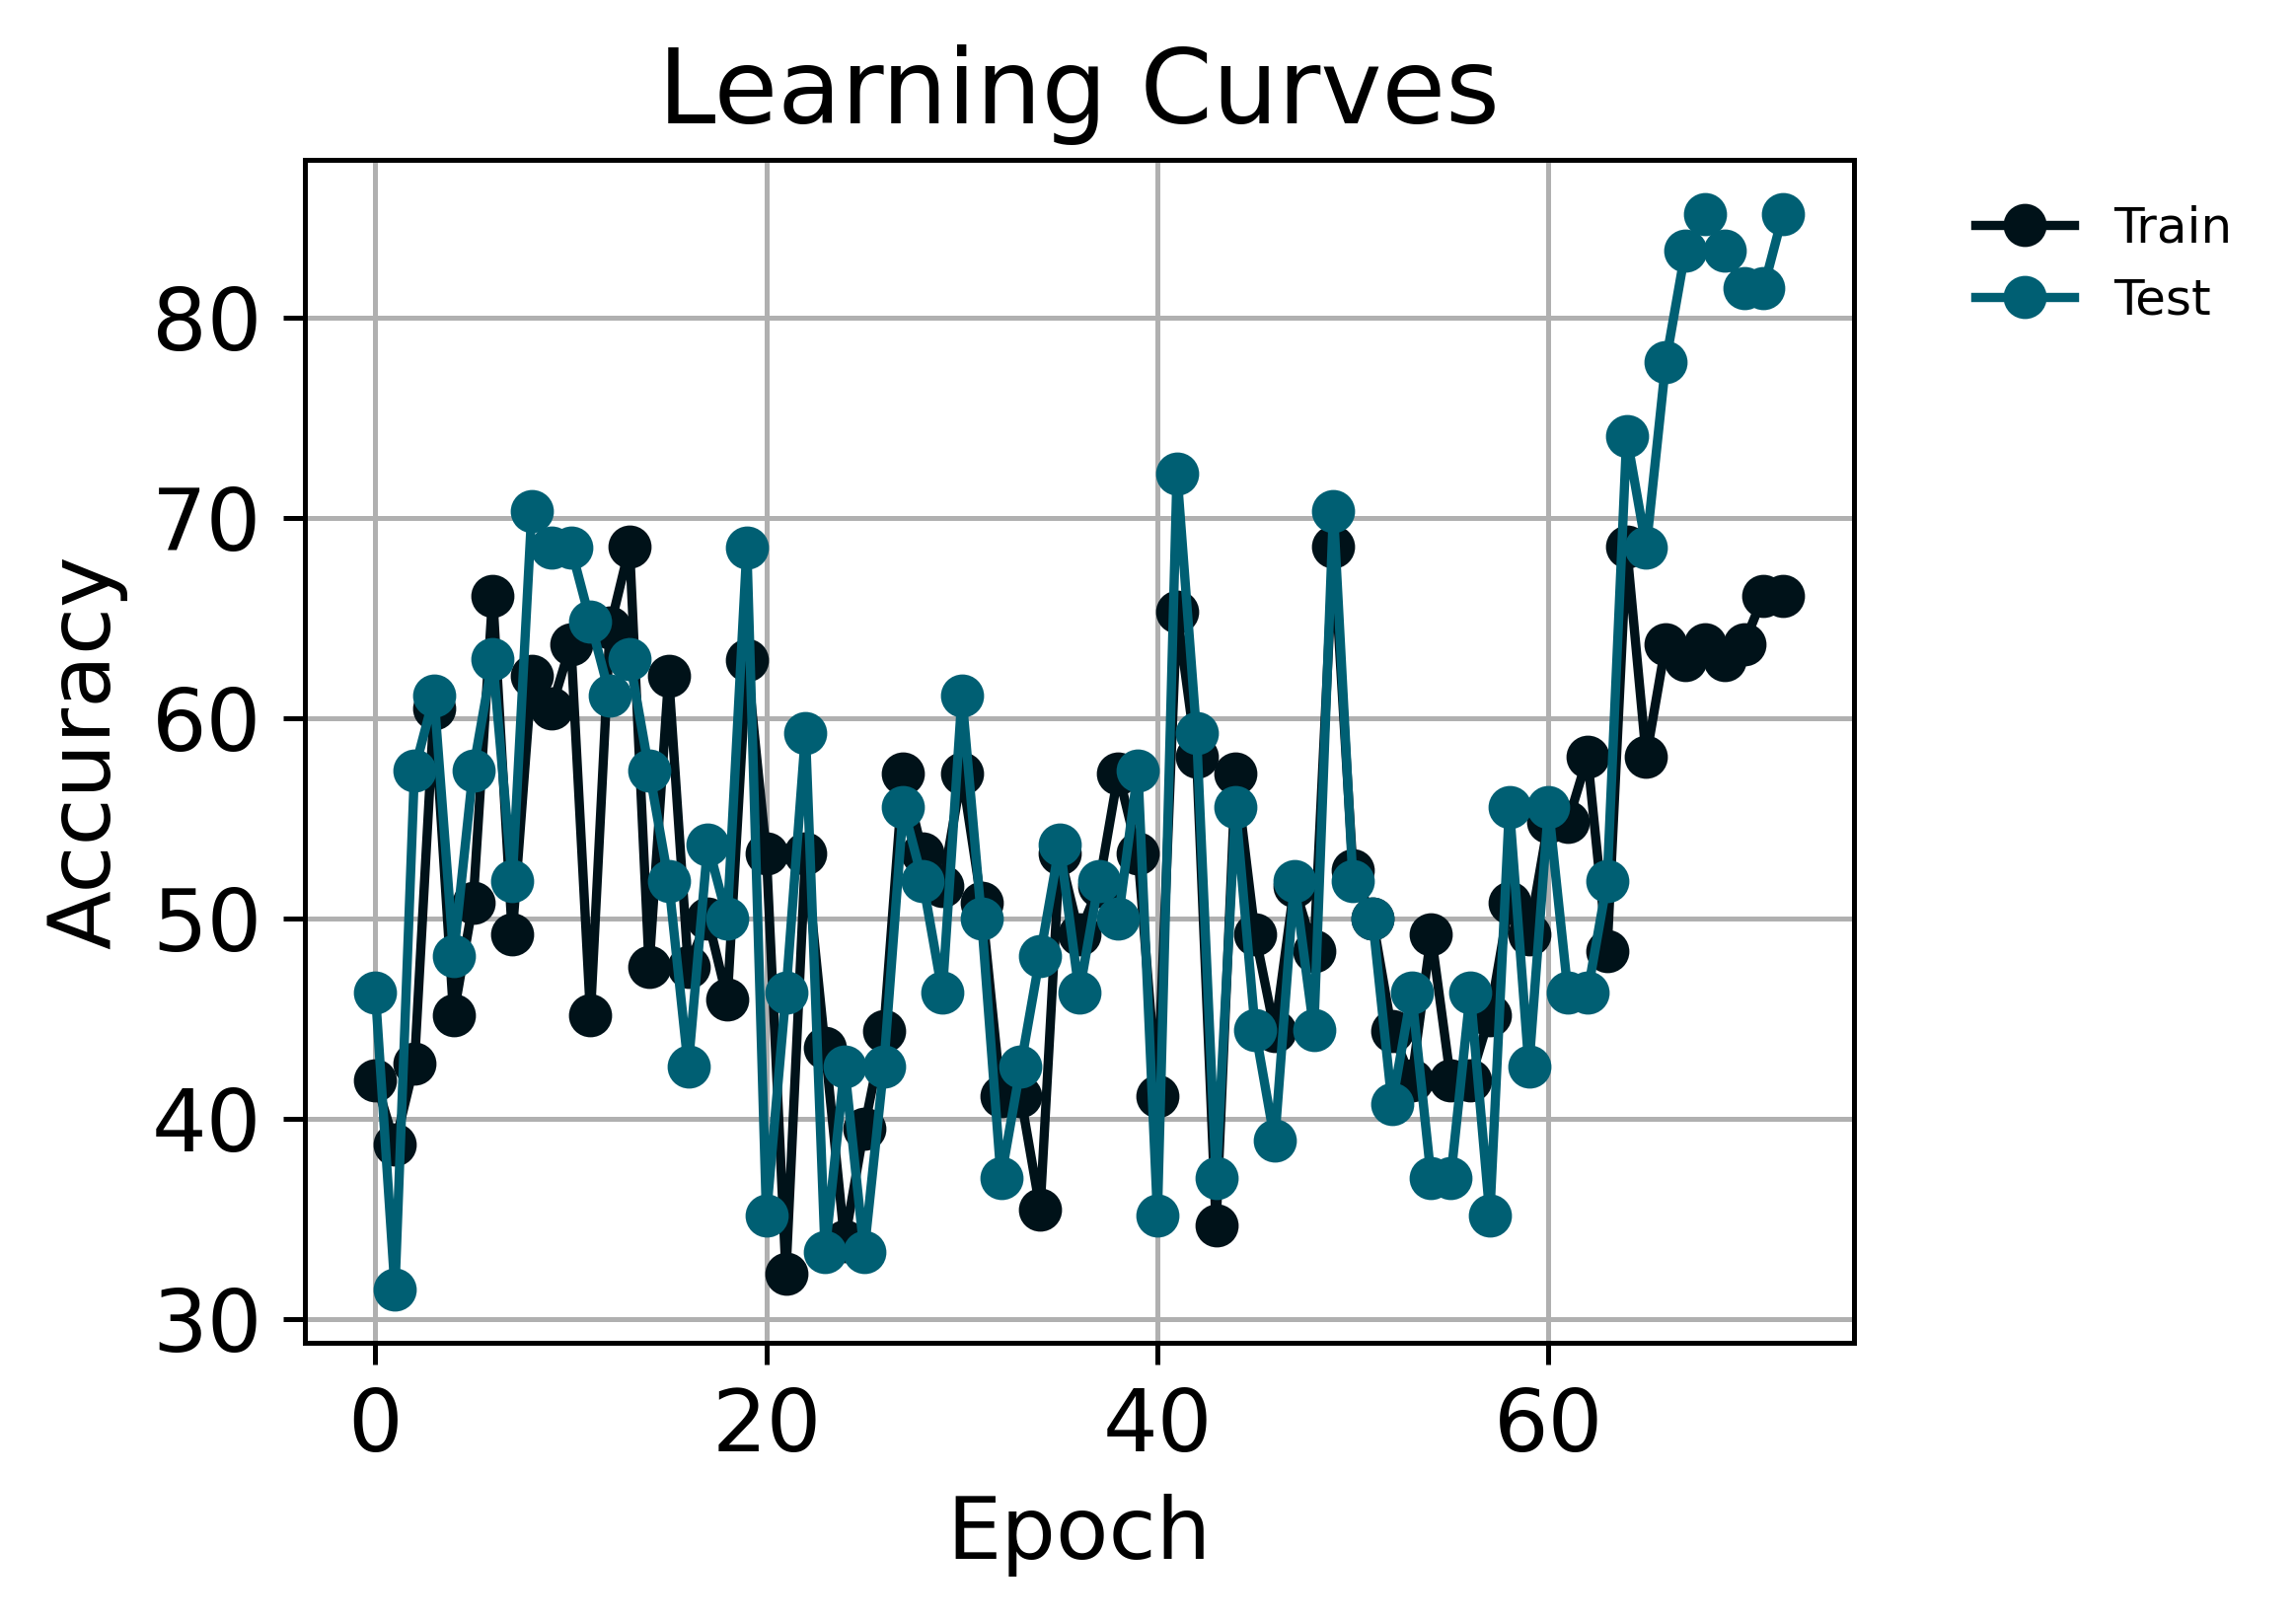

In [7]:
EPOCHS = 6
LAYERS = 2

test_accuracy_scores = []
train_accuracy_scores = []

epoch_extras = 0
accuracy = 0
while(accuracy<74.5):
    epoch_extras+=1

    model = QNN(num_layers=LAYERS, num_features=X_train.shape[1])

    # # Apply constraints to parameter ranges
    threshold = 4*np.pi

    for param in model.parameters():
        param.data.clamp_(-threshold, threshold)

    optimizer = torch.optim.RMSprop(model.parameters())
    loss_func = nn.CrossEntropyLoss()

    # Set the model to training mode
    model.train()

    for batch_idx, (data, target) in enumerate(train_dataloader):

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        loss = loss_func(output, target)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    accuracy_B, f1_B, precision_B, recall_B = evaluate_accuracy(train_dataloader, model, False)
    accuracy, f1, precision, recall = evaluate_accuracy(test_dataloader, model, False)
    test_accuracy_scores.append(accuracy)
    train_accuracy_scores.append(accuracy_B)

    print(accuracy)
    clear_output(True)

# Iterate over the training data for a fixed number of epochs
for epoch in range(EPOCHS):

    for batch_idx, (data, target) in enumerate(train_dataloader):

        # Zero the gradients
        optimizer.zero_grad()

         # Forward pass
        output = model(data)

        loss = loss_func(output, target)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    accuracy_B, f1_B, precision_B, recall_B = evaluate_accuracy(train_dataloader, model, False)
    accuracy, f1, precision, recall = evaluate_accuracy(test_dataloader, model, False)
    print("Epoch {}:\n\tAccuracy: {:.1f}%".format(
        epoch+1, accuracy
    ))
    test_accuracy_scores.append(accuracy)
    train_accuracy_scores.append(accuracy_B)

epochs =list(range(EPOCHS+epoch_extras))
accuracy, f1, precision, recall = evaluate_accuracy(test_dataloader, model, True)

# Plot the lines on the same graph
plt.plot(epochs, train_accuracy_scores, label='Train')
plt.plot(epochs, test_accuracy_scores, label='Test')
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=8)
plt.ticklabel_format(style='plain')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)  # Add a grid
plt.show()

Based on the learning curve plot, the accuracy of the Quantum Neural Network (QNN) exhibits variation for different initial points in the parameter space, which is to be expected with the model's sensitivity to the weights. Ultimately, the QNN achieves an accuracy of 84.37% on the test set, but under 70% in the train set which shows it might have underfitted. This shows that in this particular dataset the model isn't as succesful as in the Iris dataset.